In [1]:
import warnings

warnings.simplefilter(action='ignore')
import numpy as np

from variance_partitioning import variance_partitioning
from himalaya.progress_bar import bar
from residual import residual_method
from simulation import generate_dataset
import matplotlib.pyplot as plt

In [2]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

In [19]:
def plot_variance_vs_residual(x, xlabel, predicted_variance, predicted_residual, unique_contributions, n_features_list,
                              n_targets, n_samples_train, n_samples_test, noise_level, random_distribution):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    handles, labels = [], []
    for ax, predicted, method in zip(axs, [predicted_variance, predicted_residual], ["variance", "residual"]):
        line, = ax.plot(x, predicted, alpha=0.7, label=fr"predicted contribution", marker=".")

        if method == "variance":
            handles.append(line)
            labels.append(line.get_label())

        ax.set_xlabel(xlabel)
        ax.set_ylabel("predicted contribution")
        ax.set_title(f"{method}")
        ax.set_ylim([-0.1, 1.1])
        # ax.set_xlim([-0.05, 1.05])

        # draw center line
        line = ax.axhline(y=unique_contributions[0], color='k', linestyle='--', label='true contribution of $X_0$')
        if method == "variance":
            handles.append(line)
            labels.append(line.get_label())
        ax.axhline(y=0, color='k', linestyle='-', label='true contribution of $X_1$')
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.95, 0.5))
    # Add text field with variable information
    variable_info = f"n_features_list: {n_features_list}\n" \
                    f"n_targets: {n_targets}\n" \
                    f"n_samples_train: {n_samples_train}\n" \
                    f"n_samples_test: {n_samples_test}\n" \
                    f"noise_level: {noise_level}\n" \
                    f"random_distribution: {random_distribution}"
    fig.text(0.5, -0.1, variable_info, ha='center', va='center', fontsize=10)
    plt.show()

# Set default values to be used in the tests

In [4]:
n_runs = 5
unique_contributions = [0.4, 0.4]
n_features_list = [1000, 1000]
n_targets = 1000
n_samples_train = 1000
n_samples_test = 1000
noise_level = 0.0
random_distribution = "normal"

# Test varying sample sizes

In [11]:
n_sample_sizes = 11
sample_sizes = np.logspace(1, 3, n_sample_sizes)

In [12]:
predicted_varying_samples_variance = []
predicted_varying_samples_residual = []

for sample_size in bar(sample_sizes, title=f"varying sample sizes"):
    sample_size = int(sample_size)
    variance_runs = []
    residual_runs = []
    for run in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=n_features_list, n_targets=n_targets,
            n_samples_train=sample_size, n_samples_test=sample_size,
            noise=noise_level, unique_contributions=unique_contributions,
            random_distribution=random_distribution, random_state=run)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=True)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=False)
        variance_runs.append(predicted_variance)
        residual_runs.append(predicted_residual)
    predicted_varying_samples_variance.append(np.median(variance_runs))
    predicted_varying_samples_residual.append(np.median(residual_runs))

[........................................] 100% | 155.51 sec | varying sample sizes | 


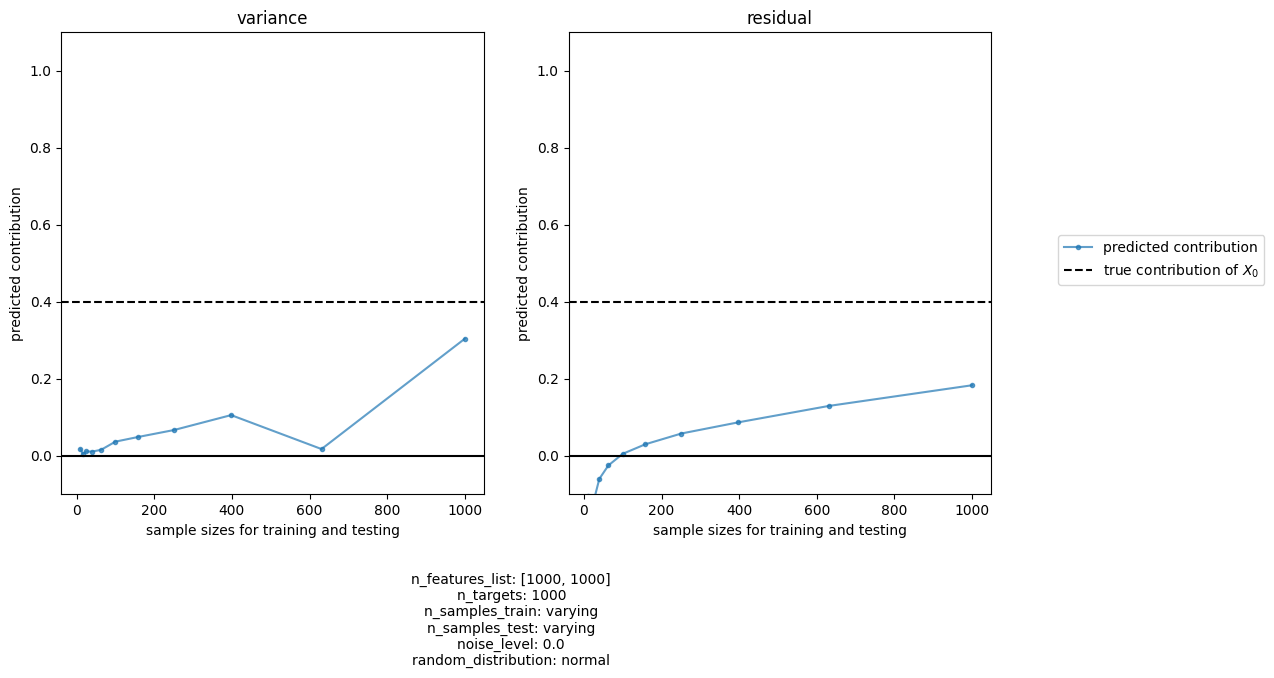

In [13]:
plot_variance_vs_residual(sample_sizes, "sample sizes for training and testing", predicted_varying_samples_variance,
                          predicted_varying_samples_residual,
                          unique_contributions, n_features_list, n_targets, "varying", "varying", noise_level,
                          random_distribution)

# Test varying feature sizes

In [13]:
n_feature_sizes = 11
feature_sizes = np.logspace(0, 3, n_feature_sizes)

In [21]:
predicted_varying_feature_variance = []
predicted_varying_feature_residual = []

for feature_size in bar(feature_sizes, title=f"varying feature sizes"):
    feature_size = int(feature_size)
    variance_runs = []
    residual_runs = []
    for run in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=[feature_size, feature_size], n_targets=n_targets,
            n_samples_train=n_samples_train, n_samples_test=n_samples_test,
            noise=noise_level, unique_contributions=unique_contributions,
            random_distribution=random_distribution, random_state=run)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=True)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=False)
        variance_runs.append(predicted_variance)
        residual_runs.append(predicted_residual)
    predicted_varying_feature_variance.append(np.median(variance_runs))
    predicted_varying_feature_residual.append(np.median(residual_runs))

[........................................] 100% | 191.78 sec | varying feature sizes | 


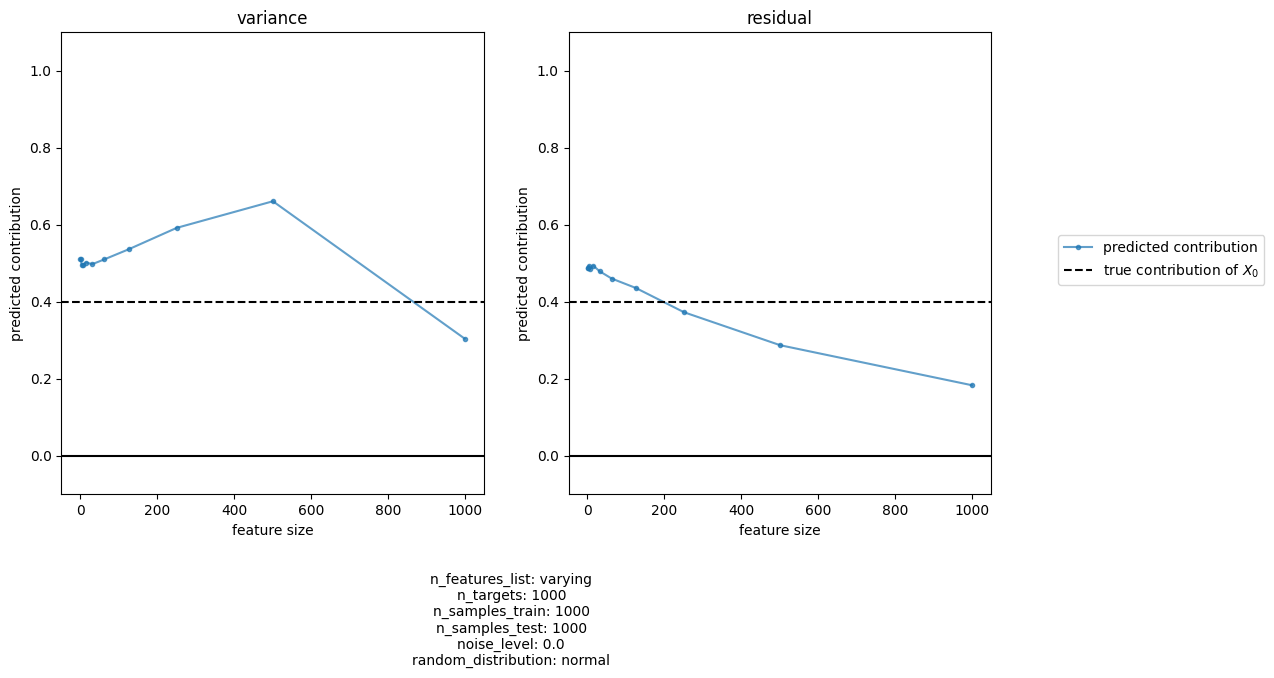

In [22]:
plot_variance_vs_residual(feature_sizes, "feature size", predicted_varying_feature_variance,
                          predicted_varying_feature_residual, unique_contributions, "varying", n_targets,
                          n_samples_train, n_samples_test, noise_level, random_distribution)

# Test varying ratios between feature sizes and target sizes

In [23]:
n_testing_sizes = 11
target_ratios = np.linspace(0, 1, n_testing_sizes)

In [26]:
predicted_varying_target_variance = []
predicted_varying_target_residual = []

for target_ratio in bar(target_ratios, title=f"varying target ratios"):
    targets = max(1, int(n_features_list[0] * target_ratio))

    variance_runs = []
    residual_runs = []
    for random_state in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=n_features_list, n_targets=targets,
            n_samples_train=n_samples_train, n_samples_test=n_samples_test,
            noise=noise_level, unique_contributions=unique_contributions,
            random_distribution=random_distribution,
            random_state=random_state)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=True)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=False)
    predicted_varying_target_variance.append(np.median(variance_runs))
    predicted_varying_target_residual.append(np.median(residual_runs))

[........................................] 100% | 237.60 sec | varying target ratios | 


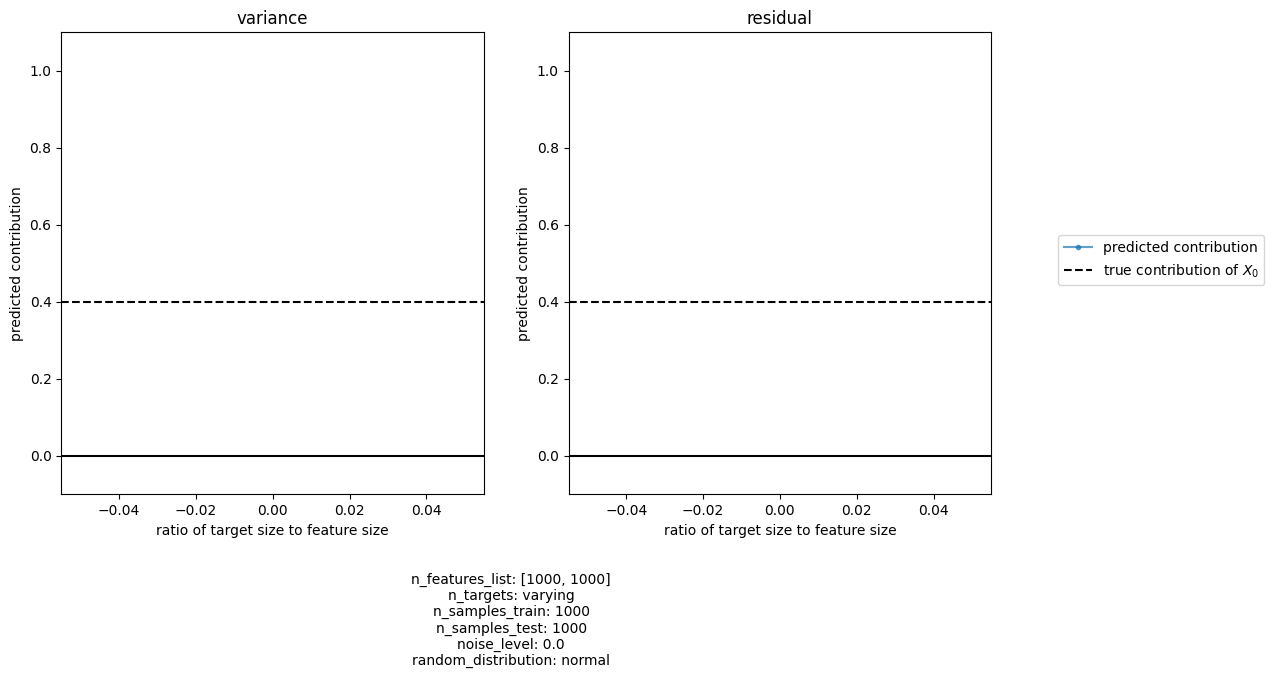

In [27]:
plot_variance_vs_residual(target_ratios, "ratio of target size to feature size", predicted_varying_target_variance,
                          predicted_varying_target_residual, unique_contributions, n_features_list, "varying",
                          n_samples_train, n_samples_test, noise_level,
                          random_distribution)

# Test varying noise levels

In [37]:
n_noise_levels = 11
noise_levels = np.linspace(0, 1, n_noise_levels)

In [38]:
predicted_varying_noise_variance = []
predicted_varying_noise_residual = []

for noise_level in bar(noise_levels, title=f"Testing noise levels: {noise_levels}"):
    variance_runs = []
    residual_runs = []
    for random_state in range(n_runs):
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=n_features_list, n_targets=n_targets,
            n_samples_train=n_samples_train, n_samples_test=n_samples_test,
            noise=noise_level, unique_contributions=unique_contributions,
            random_distribution=random_distribution,
            random_state=1)

        predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=True)
        predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=False)
        variance_runs.append(predicted_variance)
        residual_runs.append(predicted_residual)
    predicted_varying_noise_variance.append(np.median(variance_runs))
    predicted_varying_noise_residual.append(np.median(residual_runs))

[........................................] 100% | 64.37 sec | Testing noise levels: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] | 


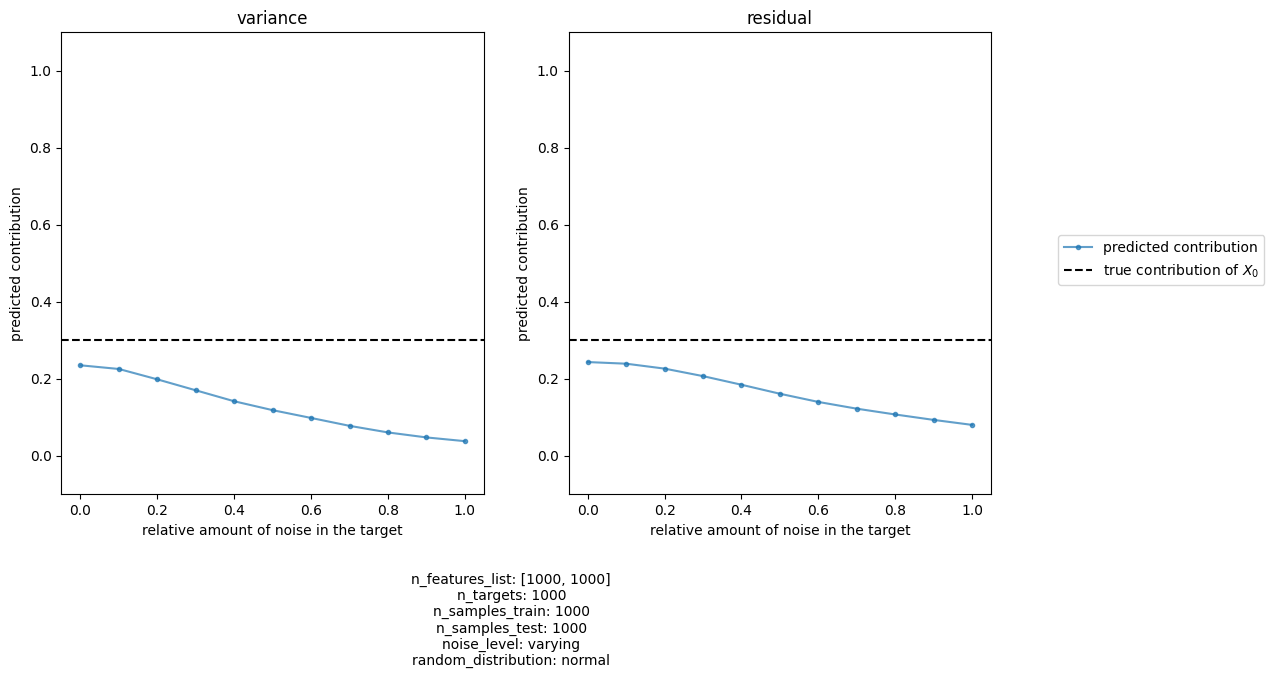

In [46]:
plot_variance_vs_residual(noise_levels, "relative amount of noise in the target", predicted_varying_noise_variance,
                          predicted_varying_noise_residual, unique_contributions,
                          n_features_list, n_targets, n_samples_train, n_samples_test, "varying", random_distribution)

# Test varying unique contributions of $X_0$ and $X_1$

In [28]:
n_contributions = 5
x0_unique_contributions = np.linspace(0, 1, n_contributions)

In [ ]:
# Initialize predicted_variance and predicted_residual with separate lists
predicted_varying_contribution_variance = [[0] * n_contributions for _ in range(n_contributions)]
predicted_varying_contribution_residual = [[0] * n_contributions for _ in range(n_contributions)]

# create 2d data with unique contribution of X0 and X1 varying
for x0, x0_unique_contribution in enumerate(x0_unique_contributions):
    for x1 in bar(range(n_contributions), title=rf"$X_0$: {x0_unique_contribution}"):
        variance_runs = []
        residual_runs = []

        for random_state in range(n_runs):
            X1_unique_contribution = (1 - x0_unique_contribution) * x1 / (n_contributions - 1)
            (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
                n_features_list=n_features_list, n_targets=n_targets,
                n_samples_train=n_samples_train, n_samples_test=n_samples_test,
                noise=noise_level, unique_contributions=[x0_unique_contribution, X1_unique_contribution],
                random_distribution=random_distribution,
                random_state=random_state)

            predicted_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=True)
            predicted_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=False)
            variance_runs.append(predicted_variance)
            residual_runs.append(predicted_residual)

        predicted_varying_contribution_variance[x1][x0] = np.median(variance_runs)
        predicted_varying_contribution_residual[x1][x0] = np.median(residual_runs)

[........                                ] 20% | 13.10 sec | $X_0$: 0.0 | 

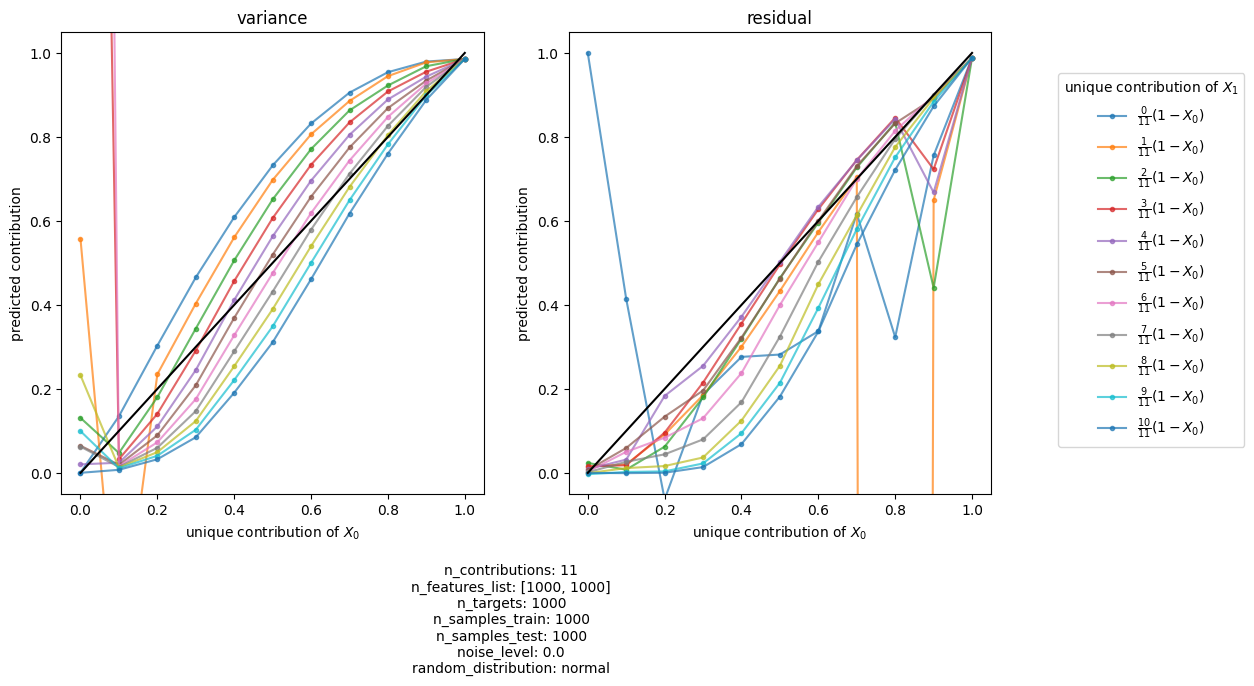

In [33]:
# Collect variable information
variable_info = f"n_contributions: {n_contributions}\n" \
                f"n_features_list: {n_features_list}\n" \
                f"n_targets: {n_targets}\n" \
                f"n_samples_train: {n_samples_train}\n" \
                f"n_samples_test: {n_samples_test}\n" \
                f"noise_level: {noise_level}\n" \
                f"random_distribution: {random_distribution}"

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
handles, labels = [], []

for ax, predicted, method in zip(axs,
                                 [predicted_varying_contribution_variance, predicted_varying_contribution_residual],
                                 ["variance", "residual"]):
    for x1, x0_unique_contribution in enumerate(x0_unique_contributions):
        X1_unique_contribution = (1 - x0_unique_contribution) * x1 / (n_contributions - 1)
        line, = ax.plot(x0_unique_contributions, predicted[x1], alpha=0.7,
                        label=fr"$\frac{{{x1}}}{{{n_contributions}}}(1-X_0)$", marker=".")

        if method == "variance":
            handles.append(line)
            labels.append(line.get_label())
    ax.plot(x0_unique_contributions, x0_unique_contributions, color="black")

    ax.set_xlabel(r"unique contribution of $X_0$")
    ax.set_ylabel("predicted contribution")
    # ax.legend(title=r"unique contribution of $X_1$")
    ax.set_title(f"{method}")
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([-0.05, 1.05])

fig.legend(handles, labels, title=r"unique contribution of $X_1$", loc='center left', bbox_to_anchor=(0.95, 0.5))

# Add text field with variable information
fig.text(0.5, -0.1, variable_info, ha='center', va='center', fontsize=10)

plt.show()